In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ROM
import lal, lalsimulation
from itertools import combinations 

In [3]:
# Define a few aesthetic colours using Hex codes
myblue   = '#0F56B5'
myred    = '#EF4647'
mygrey   = '#666666'
mygreen  = '#2CA02C'
mypurple = '#9467bd'

rc_params = {
    'backend': 'pdf',
    'axes.labelsize': 24,
    'axes.titlesize': 32,
    'font.size': 24,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'serif',
    'font.sans-serif': ['Bitstream Vera Sans'],
    'font.serif': ['Times New Roman'],
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}',
    'text.usetex':True,
    'axes.linewidth':1.75,
    'patch.force_edgecolor':True
}
plt.rcParams.update(rc_params);

In [4]:
def generate_waveforms(
duration,            # Length in geometric units to truncate the waveform to
mass_1,              # Mass of primary in solar masses
mass_2,              # Mass of secondary in solar masses
l_max,
modes,
                     # To generate a waveform model in the time domain, we need to specify the binary parameters
f_min        = 20.,  # Starting frequency
f_ref        = 20.,  # Reference frequency
delta_t      = 1/2048,# Sampling time (e.g. 1/2048 Hz)
phase        = 0.0,  # Phase at reference frequency
                     # Dimensionful spin, S_i = m^2_i * \chi_i 
                     # Frame is defined such that \hat{L} is pointing along \hat{z}
chi_1x       = 0,    # Dimensionless spin of primary in x-direction
chi_1y       = 0,    # Dimensionless spin of primary in y-direction
chi_1z       = 0,    # Dimensionless spin of primary in z-direction
chi_2x       = 0,    # Dimensionless spin of secondary in x-direction
chi_2y       = 0,    # Dimensionless spin of secondary in y-direction
chi_2z       = 0,    # Dimensionless spin of secondary in z-direction
inclination  = 0.5,  # Inclination of L (orbital ang. mom.) with respect to J (total ang. mom.)
distance     = 100 * 1e6 * lal.PC_SI, # Luminosity distance in SI units
longAscNodes = 0,
meanPerAno   = 0,
eccentricity = 0,
laldict      = lal.CreateDict(), # LAL Dictionary (allows us to pass additional flags and options to the waveform generator
verbose      = False
):
    hlm         = lalsimulation.SimInspiralChooseTDModes(phase,delta_t,mass_1,
                                                    mass_2,chi_1x, chi_1y, chi_1z,
                                                    chi_2x, chi_2y, chi_2z,
                                                    f_min,f_ref, distance, laldict, l_max, 
                                                    lalsimulation.IMRPhenomTHM
                                                )
    
    time_array = lalsimulation.SphHarmTimeSeriesGetMode(hlm, 2, 2).deltaT * np.arange(len(lalsimulation.SphHarmTimeSeriesGetMode(hlm, 2, 2).data.data))
    hlms = lalsimulation.SphHarmTimeSeriesGetMode(hlm, 2, 2).data.data

    # Sets the arrays such that the peak amplitudes line up time-wise
    strain = np.zeros(len(hlms))
    strain += np.abs(hlms)**2
    t_max = time_array[np.argmax(strain)]
    time_array -= t_max

    # Geometric unit conversion and waveform truncation
    mass_total = (mass_1 + mass_2)/lal.MSUN_SI
    mass_ratio = mass_1/mass_2 
    time_geom = time_array/(mass_total * lal.MTSUN_SI)
    hlms_geom = hlms * distance / (mass_total * lal.MRSUN_SI)
    
    waveform_length = duration * mass_total * lal.MTSUN_SI
    array_length = int(np.floor(waveform_length/delta_t))

    time_trunc = time_geom[-array_length:]
    hlms_trunc = hlms_geom[-array_length:]

    return time_trunc, hlms_trunc

In [5]:
# Define some parameters regarding the masses. q is a mass ratio (m1/m2)
q = np.arange(1, 10, 0.1)
mass_total = 50 * lal.MSUN_SI
m_1 = (mass_total*q)/(q+1)
m_2 = mass_total/(q+1)
l_max = 2
modes = [(l,m) for l in range(2,l_max+1) for m in range(-l,l+1)]
distance = 100 * 1e6 * lal.PC_SI
delta_t = 1/2048

# Waveforms can take many modes. E.g the 2,2 mode is obtained via waveforms[x][(2,2)]
data = [generate_waveforms(5000, m_1[i],m_2[i], l_max, modes, distance=distance, delta_t=delta_t) for i in range(len(q))]
times, waveforms = zip(*data)
mode_22 = np.asarray([waveforms[i] for i in range(len(waveforms))])

In [6]:
RB = ROM.modified_GS(mode_22, times[0])
points, B = ROM.empirical_interpolation(RB)

In [7]:
# Selects a test waveform to form an interpolant
h = mode_22[0]
t = times[0]

# Rebuilds waveform using interpolation (dot product of B and h evaluated at nodes)
interpolant = np.dot(B, h[points])

plt.plot(t, np.real(h))
plt.plot(t, np.real(interpolant), linestyle='--')
plt.show()

/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/3750808447.py:10: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Now I am going to treat the phase and amplitude separately. This should deal with the lack of orthogonality of the RB.

In [8]:
amps = np.abs(mode_22)
phases = np.unwrap(np.angle(mode_22))

RB_amps = ROM.modified_GS(amps, times[0], verbose=False)
points_amps, B_amps = ROM.empirical_interpolation(RB_amps)

RB_phases = ROM.modified_GS(phases, times[0], verbose=False)
points_phases, B_phases = ROM.empirical_interpolation(RB_phases)

A = amps[0]
phi = phases[0]
t = times[0]

interpolant_amp = np.dot(B_amps, A[points_amps])
interpolant_phase = np.dot(B_phases, phi[points_phases])

# plt.loglog(errors)
# plt.xlabel('Iterations')
# plt.ylabel('Error')
# plt.tight_layout()
# plt.savefig('figures/errors_timewave', dpi=300)
# plt.show()

plt.plot(t, A, label='Original')
plt.plot(t, interpolant_amp, label='Interpolant',linestyle='--')
plt.xlabel('Time/$M_\odot$')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.legend()
plt.savefig('figures/amp_EI.png', dpi=300)
plt.show()

plt.plot(t, phi, label='Original')
plt.plot(t, interpolant_phase, label='Interpolant',linestyle='--')
plt.xlabel('Time/$M_\odot$')
plt.ylabel('Phase')
plt.tight_layout()
plt.legend()
plt.savefig('figures/phase_EI.png', dpi=300)
plt.show()

/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/2420122199.py:31: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/2420122199.py:40: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [9]:
plt.plot(t, np.real(mode_22[0]))
plt.xlabel('Time/$M_\odot$')
plt.ylabel('Strain')
plt.tight_layout()
plt.savefig('figures/waveform.png', dpi=300)
plt.show()

/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/1276748109.py:6: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [10]:
# Now to recombine the amplitude and phase from the interpolants

recombined_strains = amps*np.exp(1j*phases)
test_strain = recombined_strains[5]

plt.plot(t, np.real(mode_22[5]), label='Original')
plt.plot(t, np.real(test_strain), label='Interpolant', linestyle='--')
plt.xlabel('Time/$M_\odot$')
plt.ylabel('Strain')
plt.tight_layout()
plt.legend()
plt.savefig('figures/interpolant.png', dpi=300)
plt.show()

/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/187233352.py:13: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [11]:
from pycbc.filter import match
from pycbc import types, fft, waveform, psd

# Mismatch
h_plus_A = mode_22[5].real
h_plus_B = test_strain.real

hpA = types.TimeSeries(h_plus_A,delta_t=1/2048)
hpB = types.TimeSeries(h_plus_B,delta_t=1/2048)

# Resize the waveforms to the same length
tlen = max(len(hpA), len(hpB))

# Generate the aLIGO ZDHP PSD
delta_f   = 1.0 / hpA.duration
f_len     = tlen//2 + 1
f_low     = 20.0 
det_psd   = psd.aLIGOLateHighSensitivityP1200087(f_len, delta_f, f_low)
     

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hpA, hpB, psd=det_psd, low_frequency_cutoff=f_low)
print(m)

1.0


In [12]:
plt.plot(times[0], mode_22[0])
plt.plot(times[0], mode_22[50])
plt.show()

/usr/local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/516082817.py:3: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [13]:
diff = mode_22[0] - test_strain
plt.plot(t, np.real(diff))
plt.xlabel('Time/$M_\odot$')
plt.ylabel('$\epsilon$')
plt.tight_layout()
plt.savefig('figures/diff_interpolant_time.png', dpi=300)
plt.show()

print(ROM.get_norm(diff, t))

5.402991953255137


/var/folders/99/p9l8gcl141vf76_vh206t0d00000gn/T/ipykernel_93650/3716771077.py:7: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


2.041310553880575
--- 0.0012028217315673828 seconds ---
--- 0.005494117736816406 seconds ---


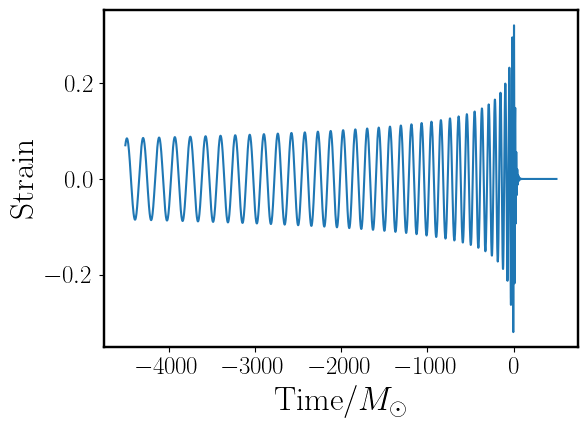

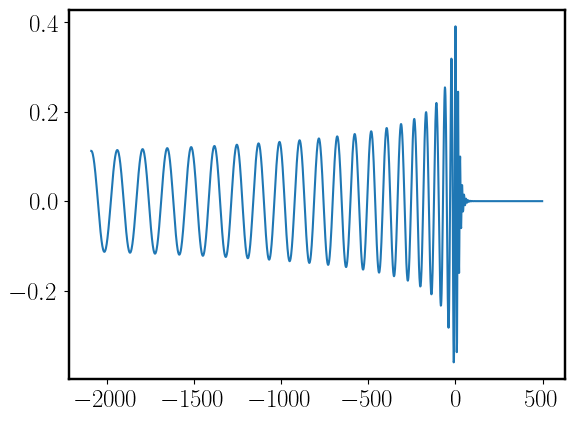

In [34]:

# Define some parameters regarding the masses. q is a mass ratio (m1/m2)
q = np.arange(1, 10, 0.1)
mass_total = 50 * lal.MSUN_SI
m_1 = (mass_total*q)/(q+1)
m_2 = mass_total/(q+1)
l_max = 2
modes = [(l,m) for l in range(2,l_max+1) for m in range(-l,l+1)]
distance = 100 * 1e6 * lal.PC_SI
delta_t = 1/2048

# Waveforms can take many modes. E.g the 2,2 mode is obtained via waveforms[x][(2,2)]
data = [generate_waveforms(5000, m_1[i],m_2[i], l_max, modes, distance=distance, delta_t=delta_t) for i in range(len(q))]
times, waveforms = zip(*data)
mode_22 = np.asarray([waveforms[i] for i in range(len(waveforms))])

# Fitting the nodes as a function of the input parameter
amps = np.abs(mode_22)
phases = np.unwrap(np.angle(mode_22))

RB_amps = ROM.modified_GS(amps, times[0], verbose=False)
points_amps, B_amps = ROM.empirical_interpolation(RB_amps)

RB_phases = ROM.modified_GS(phases, times[0], verbose=False)
points_phases, B_phases = ROM.empirical_interpolation(RB_phases)

A = amps[0]
phi = phases[0]
t = times[0]

interpolant_amp = np.dot(B_amps, A[points_amps])
interpolant_phase = np.dot(B_phases, phi[points_phases])
# Generate some fits for the amplitude and phase
amp_fits = ROM.get_polyfit(q, amps, points_amps)
phase_fits = ROM.get_polyfit(q, phases, points_phases)

# Obtain the waveform form the fit
test_parameter = 2.041310553880575
print(test_parameter)
import time
start_time = time.time()

x = []
for k in range(len(points_amps)):
    x.append(ROM.fit_waveform(test_parameter, amp_fits[k]))
y_amp = np.dot(B_amps, x)

x = []
for k in range(len(points_phases)):
    x.append(ROM.fit_waveform(test_parameter, phase_fits[k]))
y_phase = np.dot(B_phases, x)

interp = np.real(y_amp*np.exp(1j*y_phase))

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

mass_ratio = test_parameter
mass_total = 50 * lal.MSUN_SI
m_1 = (mass_total*mass_ratio)/(mass_ratio+1)
m_2 = mass_total/(mass_ratio+1)
l_max = 2
modes = [(l,m) for l in range(2,l_max+1) for m in range(-l,l+1)]
distance = 100 * 1e6 * lal.PC_SI
delta_t = 1/2048

times_real, real_wave = generate_waveforms(duration=5000, mass_1=m_1, mass_2=m_1, l_max=l_max, modes=modes, distance=distance, delta_t=delta_t)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(t, interp)
plt.xlabel('Time/$M_\odot$')
plt.ylabel('Strain')
plt.tight_layout()
# plt.savefig('figures/polyfit_time.png', dpi=300)
plt.show()

plt.plot(times_real, real_wave)
plt.show()

In [41]:
interp_trunc = interp[(len(interp)-len(real_wave)):]
interp_trunc.shape
mode_22[0].shape
real_wave.shape

(1754,)

/usr/local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


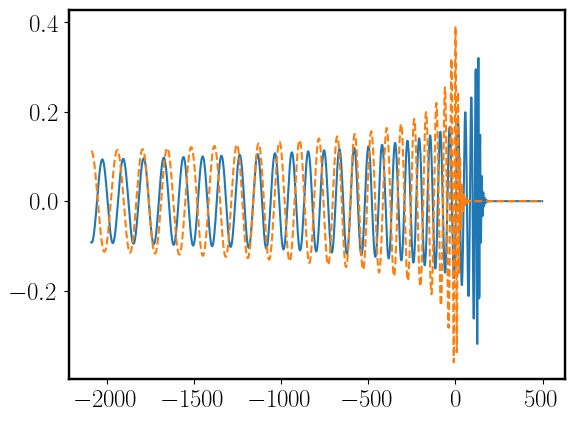

In [39]:
plt.plot(times_real, interp_trunc)
plt.plot(times_real, real_wave, linestyle='--')
plt.show()

In [15]:
q = 2.041310553880575
mass_total = 50 * lal.MSUN_SI
m_1 = (mass_total*q)/(q+1)
m_2 = mass_total/(q+1)
l_max = 2
modes = [(l,m) for l in range(2,l_max+1) for m in range(-l,l+1)]
distance = 100 * 1e6 * lal.PC_SI
delta_t = 1/2048
actual_wave = generate_waveforms(5000, m_1, m_1, l_max=l_max, modes=modes)[0]

from pycbc.filter import match
from pycbc import types, fft, waveform, psd

# Mismatch
h_plus_A = np.real(y_amp*np.exp(1j*y_phase))
h_plus_B = actual_wave.real

hpA = types.TimeSeries(h_plus_A,delta_t=1/2048)
hpB = types.TimeSeries(h_plus_B,delta_t=1/2048)

# Resize the waveforms to the same length
tlen = max(len(hpA), len(hpB))

# Generate the aLIGO ZDHP PSD
delta_f   = 1.0 / hpA.duration
f_len     = tlen//2 + 1
f_low     = 20.0 
det_psd   = psd.aLIGOLateHighSensitivityP1200087(f_len, delta_f, f_low)
     

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hpA, hpB, psd=det_psd, low_frequency_cutoff=f_low)
print(m)

ValueError: Length of template and data must match

In [46]:
start_time = time.time()
l_max = 2
modes = [(l,m) for l in range(2,l_max+1) for m in range(-l,l+1)]
distance = 100 * 1e6 * lal.PC_SI
delta_t = 1/2048
times_real, real_wave = generate_waveforms(duration=5000, mass_1=m_1, mass_2=m_1, l_max=l_max, modes=modes, distance=distance, delta_t=delta_t)
print((time.time() - start_time))

x = np.linspace(1, 5000, 5000)
start_time = time.time()
wave = x**4
print(time.time()-start_time)

0.010254859924316406
0.0003762245178222656


A waveform has been generated using a polynomial fit.

Let's find the 'mismatch' between an original waveform and the interpolated waveform.